In [1]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
import csv

## Group Assignment
### Team Number: 06
### Team Member Names: Alan, Andrew, Haaris
### Team Strategy Chosen: Risky

# Introducing: The6ixRoboAdvisor
Our team of developers have come up with a three-staged algorithmic process, to take a list of stock tickers and provide an in-depth investment recommendation to clients using the stocks provided. This investment's purpose is to see the largest deviation from the portfolio's starting value after the week, whether that be through a loss in portfolio value or a gain. 

The first step involves a filtration process. This first step of our algorithm is meant to read in the provided tickers and remove all tickers that do not fall under the given criteria from consideration. If a stock does match our criteria, deemed appropriate for consideration all relevant information such as it's ticker, daily close price and daily rate of return for every day since March 1, 2022 are stored to be used in the next step of the algorithm, data analysis.

In this second step of our RoboAdvisor, we use historical stock data to calculate crucial figures related to the volatility of the stocks remaining. The main purpose of this section is to determine possible "hero" stocks, defined as stocks that we have outlined as especially volatile, that could potentially drive our final portfolio. Essentially, we know that any level of diversification will most likely decrease the overall deviation of our final portfolio. Therefore, the first part of our strategy is determining the most volatile stock, by different figures. Additionally, we will always invest in 12 stocks, as diversification is counterintuitive to our goal. We use, maximum standard deviation (most volatile), maximum beta value (most volatile in upward direction) and minimum beta value (most volatile in downward direction), identifying which stock applies for each of these categories and labeling each as a "hero stock". For each of these three hero stocks we determine the correlation between the remaining stocks and it. For each hero stock, the 11 securities with the closest correlation are added to a portfolio with the hero stock. This way these 11 securities are as close as possible to this "most volatile stock". This allows us to end with 3 lists containing 12 stock tickers each, with one of the 12 already identified as the hero stock.

Next we run a week long stock simulator, seeing which of the 3 hero stocks has the higehst deviation each week. This process occurs for every 5 trding day chain from March 1, 2022 until present day. For each iteration, the hero stock that deviates the most from it's starting value gets 1 point as the winner. By the end of the simulations, the hero stock with the most winner points is determined the most risky stock. 

Now that the final most volatile stock has been identified we must invest in a minimum of 12 stocks, with a minimum of 100/(2n)% of the starting investment amount in each stock (n = total number of stocks) and a maximum of 25%. After some calculations we determine weightings of the portfolio that comply with these rules and put as much money as possible in the hero stock, and then those most closely correlated. Once the weightings are determined we can calculate the number of shares to purchase of each portfolio and return our final comprehensive investment portfolio as determined by our RoboAdvisor!

 # Reading In Tickers
 The function read_in_tickers(filename) takes a filename and reads in the file as a dataframe. It takes the tickers provided and outputs them stored in a flat list tickers_list. The function is called for the file "Tickers.csv".

In [2]:
def read_in_tickers(filename):
    tickers = pd.read_csv(filename, header=None)
    tickers.columns = ["Ticker"]   #Gives title for tickers column
    return tickers.Ticker.tolist()
tickers_list = read_in_tickers('Tickers.csv')
tickers_list

['AAPL',
 'ABBV',
 'ABT',
 'ACN',
 'AGN',
 'AIG',
 'AMZN',
 'AXP',
 'BA',
 'BAC',
 'BIIB',
 'BK',
 'BLK',
 'BMY',
 'C',
 'CAT',
 'CELG',
 'CL',
 'CMCSA',
 'COF',
 'COP',
 'COST',
 'CSCO',
 'CVS',
 'GM',
 'GOOG',
 'JPM',
 'KMI',
 'KO',
 'LLY',
 'LMT',
 'MO',
 'MON',
 'MRK',
 'MS',
 'MSFT',
 'NEE',
 'NKE',
 'ORCL',
 'OXY',
 'PCLN',
 'PEP',
 'PFE',
 'PG',
 'PM',
 'PYPL',
 'QCOM',
 'RTN',
 'RY.TO',
 'SBUX',
 'SLB',
 'SO',
 'SPG',
 'T',
 'TD.TO',
 'TGT',
 'TWX',
 'TXN',
 'UNH',
 'UNP',
 'UPS',
 'USB']

 # Determining Invalid Months
The function invalid_months(start_date, end_date) takes a start and end date and returns a list of months which have under 20 trading days. This list of months will be useful for the main filter functions as they are not considered for average volume calculations.

In [3]:
#Find months considered invalid for the purposes of filtering calculations. This would be the same for all American
#securities so to boost efficiency, just calculate it for one
def invalid_months(start_date, end_date):
    months_to_remove = []
    company_data = yf.Ticker('AAPL')
    company_fin_hist = company_data.history(start=start_date, end=end_date)
    
    #For each month in the time interval (except November) we check if there are less than 20 days in the month, if so
    #we append the 'yyyy-mm' string to a list of months to remove in the filtering
    for i in range(1, 10):
        month_days = len(company_fin_hist.filter(like = f'2022-0{i}', axis=0))
        if month_days < 20:
            months_to_remove.append(f'2022-0{i}')
            
    #Follow the same process as in the for loop for the first 10 months, just for November.
    month_days = len(company_fin_hist.filter(like=f'2022-10', axis=0))
    if month_days < 20:
            months_to_remove.append(f'2022-10')
    
    #Return the lists of months to remove (which have under 20 trading days)
    return months_to_remove

#Calling the function for the given interval
vetoed_months = invalid_months('2022-01-01', '2022-11-01')
vetoed_months

['2022-02']

 # Filtering Invalid Tickers
The function filter_tickers(tickers, start_date, end_date) takes the list of generated tickers from the given csv file as well as a start and end date. For each ticker in the list of tickers we add all the tickers with an average monthly value >= 200000, in the US Market to a list of filtered tickers. Additionally we create two dataframes, one with the daily close prices from March 2022 to the current date and one with the daily rate of return over that same time period. These 3 structures are returned as a tuple and can then all be accessed for our data analysis, as they each contain necessary data.

In [4]:
def filter_tickers(tickers, start_date, end_date):
    #Empty structures to be used later
    close_price_df = pd.DataFrame()
    daily_ror_df = pd.DataFrame()
    filtered_tickers = []
    
    #For each stock in the ticker_list we will determine whether or not it is compatitble with our filtration criteria
    for ticker in tickers:
        
        #Check for empty lines and duplicates
        if ticker == '' or ticker in filtered_tickers:
            print(f'{ticker} does not exist or is already accounted for')
            continue
            
        ##Get company stock history from yfinance
        company_data = yf.Ticker(ticker)
        company_fin_hist = company_data.history(start=start_date, end=end_date)
        
        #Remove vetoed months from the stock history DataFrame (these vetoed months are the same for all stocks in the us market).
        # Since stocks in the US market will have the same trading days. Whether or not vetoed months are missed or added
        # for stocks in other markets is irrelevant as they will be filtered out anyways (since they are not part of the US market)
        for month in vetoed_months:
            company_fin_hist = company_fin_hist.drop((company_fin_hist.loc[f'{month}-01':f'{month}-28']).index)
        #Calculate average monthly volume for non-vetoed months 
        average_monthly_volume = ((company_fin_hist[company_fin_hist.index <= '2022-10-31']).Volume.sum())/(10 - len(vetoed_months))

        #If the average_monthly_volume < 200000 shares and the stock operates in the us_market it is removed
        #from consideration as we move onto the next iteration without storing any of this stocks data
        if  average_monthly_volume < 200000:
            print(f'{ticker} does not currently exist or does not have sufficient trading volume for consideration')
            continue
            
        #Get the stock information and check if or if not it is in the us market
        company_info = company_data.info
        if 'market' in company_info.keys() and company_info['market'] == 'us_market':
            
            #For stocks that pass the filter check: Add tickers to a filtered_ticker_list
            #                                       Append their close prices as a column to the Close price dataframe
            #                                       Append their daily rates of return as a column to the daily_ror_df
            filtered_tickers.append(ticker)
            close_price_df[f'{ticker} Close'] = company_fin_hist.Close
            daily_ror_df[f'{ticker} Daily Rate of Return'] = company_fin_hist.Close.pct_change()
        else:
            #Not valid us stock, move to next iteration
            print(f'{ticker} is not a valid stock listed in the American market')
            continue
        
    #We will return the filtered tickers list and data from March 1, 2022, onweards for analysis from the daily_ror_df and close_price_df
    #Since our analysis starts from March 1, 2022 we don not have to worry about the data dropped from February 2022 (when there was less than 20 trading days)
    return (filtered_tickers, close_price_df[close_price_df.index >= '2022-03-01'], (daily_ror_df[daily_ror_df.index >= '2022-03-01']).dropna())
filtered_fin_info = filter_tickers(tickers_list, '2022-01-01', '2022-11-26')
filtered_fin_info

- AGN: No data found, symbol may be delisted
AGN does not currently exist or does not have sufficient trading volume for consideration
- CELG: No data found, symbol may be delisted
CELG does not currently exist or does not have sufficient trading volume for consideration
- PCLN: No data found for this date range, symbol may be delisted
PCLN does not currently exist or does not have sufficient trading volume for consideration
- RTN: No data found, symbol may be delisted
RTN does not currently exist or does not have sufficient trading volume for consideration
RY.TO is not a valid stock listed in the American market
TD.TO is not a valid stock listed in the American market
- TWX: No data found for this date range, symbol may be delisted
TWX does not currently exist or does not have sufficient trading volume for consideration


(['AAPL',
  'ABBV',
  'ABT',
  'ACN',
  'AIG',
  'AMZN',
  'AXP',
  'BA',
  'BAC',
  'BIIB',
  'BK',
  'BLK',
  'BMY',
  'C',
  'CAT',
  'CL',
  'CMCSA',
  'COF',
  'COP',
  'COST',
  'CSCO',
  'CVS',
  'GM',
  'GOOG',
  'JPM',
  'KMI',
  'KO',
  'LLY',
  'LMT',
  'MO',
  'MON',
  'MRK',
  'MS',
  'MSFT',
  'NEE',
  'NKE',
  'ORCL',
  'OXY',
  'PEP',
  'PFE',
  'PG',
  'PM',
  'PYPL',
  'QCOM',
  'SBUX',
  'SLB',
  'SO',
  'SPG',
  'T',
  'TGT',
  'TXN',
  'UNH',
  'UNP',
  'UPS',
  'USB'],
             AAPL Close  ABBV Close   ABT Close   ACN Close  AIG Close  \
 Date                                                                    
 2022-03-01  162.465012  143.626770  116.629723  307.955933  56.881618   
 2022-03-02  165.809891  145.455048  118.791176  314.859833  59.976746   
 2022-03-03  165.481369  146.271927  119.393234  315.473083  59.357719   
 2022-03-04  162.435150  146.417801  119.827499  310.735291  56.478760   
 2022-03-07  158.582596  145.338348  117.310730  301.694916 

In [5]:
filtered_tickers_list = filtered_fin_info[0]
filtered_close_price_df = filtered_fin_info[1]
filtered_ror_df = filtered_fin_info[2]

# Strategy: Min-Maxing

In assignment 3, through diversification using different stocks from the same or different industries, we found that no matter how correlated or risky the assets we were working with (e.g. BTC and ETH), the standard deviation of our portfolio relative to our starting value was always lower than that of the riskiest stock in the portfolio. From this, we can formulate a strategy where we decrease diversification as much as possible, by putting as much of our money into one risky stock as possible, we can ensure that we have the highest variance possible.

Here is our strategy to assembling a portfolio:

### Step 1: Find a "Hero" Stock

Our portfolios are centralized around the one stock that we deem the most volatile. By putting as much money into the most volatile stock we receive, we can decrease the effects of diversification in any way and get a portfolio variance value as close to the "hero" stock as possible. We used a number of criteriafor finding a hero stock, and ran simulations to determine which criterion is the best for hero stocks.

### Step 2: Find the 11 Most Correlated Stocks

To reduce the amount of clashing movements between stocks in the final portfolio, we chose the 11 stocks that correlated most with the "hero" stock, so that the likelihood the stocks follow the same movements is higher. There are a few reasons for why we chose the rest of the portfolio this way:
- We would rather choose the minimum amount of stocks that correlate most with our hero stock, since the correlation of any other stocks we choose would be lower than any stock that we have already chosen, and would be a worse option than just investing more into stocks that correlate the most with our hero.
- Rather than the stocks with the highest/lowest beta or standard deviation, we chose to support our hero stock with the most correlated stocks because of the potential of volatile stocks clashing with each other. We would rather have a slightly less volatile stock that correlates with our risky stock the best.

### Step 3: Assigning Weights

We find our weights in the following way: we first assign as much as possible into the hero stock (25%), invest the minimum into the other 11 stocks, then with the remaining funds, invest as much as possible into the most correlated stocks. From doing this, we find we invest 25% into our "hero" stock, 25% into the most correlated stock, 12.5% into the second most correlated stock, and $\frac{100}{2\cdot 12}\%$ into each remaining stock.

Steps will be explained more in depth once we reach them.

## Measures of Stock Suitability

Here are the measures we used to determine the "hero" stocks our portfolios centered around:

### Standard Deviation

Standard Deviation is a measure of how much a set of data deviates from its mean. In this case, we found the standard deviation of the rate of return of each valid stock, then found the stock with the greatest value.

Here is the standard deviation equation:

\begin{align*}
\sigma=\sqrt{\frac{\sum(x_i-\overline{X})^2}{N}}
\end{align*}

Since we are working towards a risky portfolio, we want stocks with a high standard deviation. This means we are choosing more volatile stocks that increases the chance of fluctuating prices. To calculate for standard deviation in our list of tickers, we create a function called standard_deviation that takes in the filtered list of tickers as well as their corresponding daily rate of returns. Then, we use a for loop that iterates through the rate of returns and calculates the standard deviation for each ticker. It then appends these standard deviations to a new list. After that, we plotted all the standard deviations on a graph. Then, since we are looking for "hero" stocks, we made a function to select the ticker that produced the highest standard deviation, which would be one of our "hero" stocks.

A disadvantage of measuring standard deviation is it de-emphasizes drops in return. For example, a stock that increased by 25% then fell by 20% would have its starting value. As such, we decided to also test another measure:

In [6]:
def standard_deviation(tickers, fin_info_df):
    standard_deviation_list = []
    for tick in tickers:
        standard_dev = fin_info_df[f'{tick} Daily Rate of Return'].std()
        standard_deviation_list.append(standard_dev)
    return standard_deviation_list
list_of_stdevs = standard_deviation(filtered_tickers_list, filtered_ror_df)

In [7]:
def stdev_max(tickers, stdevs):
    max_stdev = max(stdevs)
    return (tickers[stdevs.index(max_stdev)], max_stdev)
max_deviation_stock = stdev_max(filtered_tickers_list, list_of_stdevs)[0]
max_deviation_stock

'PYPL'

### Beta

Beta is a measure of a stock's correlation with general market movements. It is calculated with the following equation:

\begin{align*}
\beta=\frac{COV(x_i,r_M)}{\sigma^2(r_M)}
\end{align*}

Where $x_i$ represents a stock's returns, $r_M$ represents market returns, the denominator represents the market variance, and the numerator represents the covariance between stock returns and market returns.

As an example of what Beta represents, a stock with a beta of $1.5$ should expect to increase $3\%$ when the market moves $2\%$.

Because of the way Beta is calculated, we find that the higher the magnitude of the beta of a stock, the more volatile it is. As such, we use this measure to get two hero stocks; the stock with the highest and lowest beta.

In [8]:
# Set Dates
start_date = '2022-01-01'
end_date = '2022-11-01'

# I decided to calculate the market betas relative to the ITOT ETF, since it is well maintained
# and regarded as a trustworthy indicator of total US market performance (including small-cap and
# mid cap companies).
market = yf.Ticker('ITOT') # Blackrock's total market etf, listed under their iShares umbrella of products
#market = yf.Ticker('SPY')
#market = yf.Ticker('VTSAX') (Vanguard's total us market etf)
market_close = market.history(start = start_date, end = end_date)['Close']

def stock_beta(stock_close):
    '''
    Reads in a series of closing prices from the set start_date and end_date of a stock and the 
    market and calculates the market beta.
    
    '''
    
    # Reading in the prices into a central DataFrame
    returns = pd.DataFrame()
    returns['market'] = market_close
    returns = returns.pct_change()
    returns = returns.dropna()
    returns['stock'] = stock_close
    
    # Calculating covariance and market variance
    market_var = returns['market'].var()
    stock_cov = returns.cov().loc['stock', 'market']
    
    return stock_cov / market_var

In [9]:
# Returns the Betas of Every Stock in a Daily Rate of Return DataFrame
def generate_stock_betas(ror_df):
    # Creating a running count of tickers and their betas
    tickers = []
    beta = []

    # iterating through the tickers in a rate-of-return dataframe
    for ticker in ror_df.columns:
        ticker_name = ticker[0 : -len(' Daily Rate of Return')]
        tickers = tickers + [ticker_name]
        beta = beta + [stock_beta(ror_df[ticker])]

    # Creating a dictionary with tickers as keys and betas as values
    beta_dic = {'tickers' : tickers, 'beta' : beta}
    beta_pf = pd.DataFrame(beta_dic)
    beta_pf = beta_pf.set_index('tickers')
    return beta_pf
stock_beta_df = generate_stock_betas(filtered_ror_df)
stock_beta_df

,beta
tickers,
AAPL,1.313093
ABBV,0.332808
ABT,0.872481
ACN,1.213432
AIG,1.081465
AMZN,1.633478
AXP,1.234780
BA,1.423475
BAC,1.088499


In [10]:
def beta_min_max(beta_list):
    ''' 
        Note: Consumes a series.
    '''
    sorted_beta_list = beta_list.sort_values()
    return ((sorted_beta_list.index[0], sorted_beta_list[0]), (sorted_beta_list.index[-1], sorted_beta_list[-1]))
max_beta_stock = beta_min_max(stock_beta_df['beta'])[1][0]
min_beta_stock = beta_min_max(stock_beta_df['beta'])[0][0]

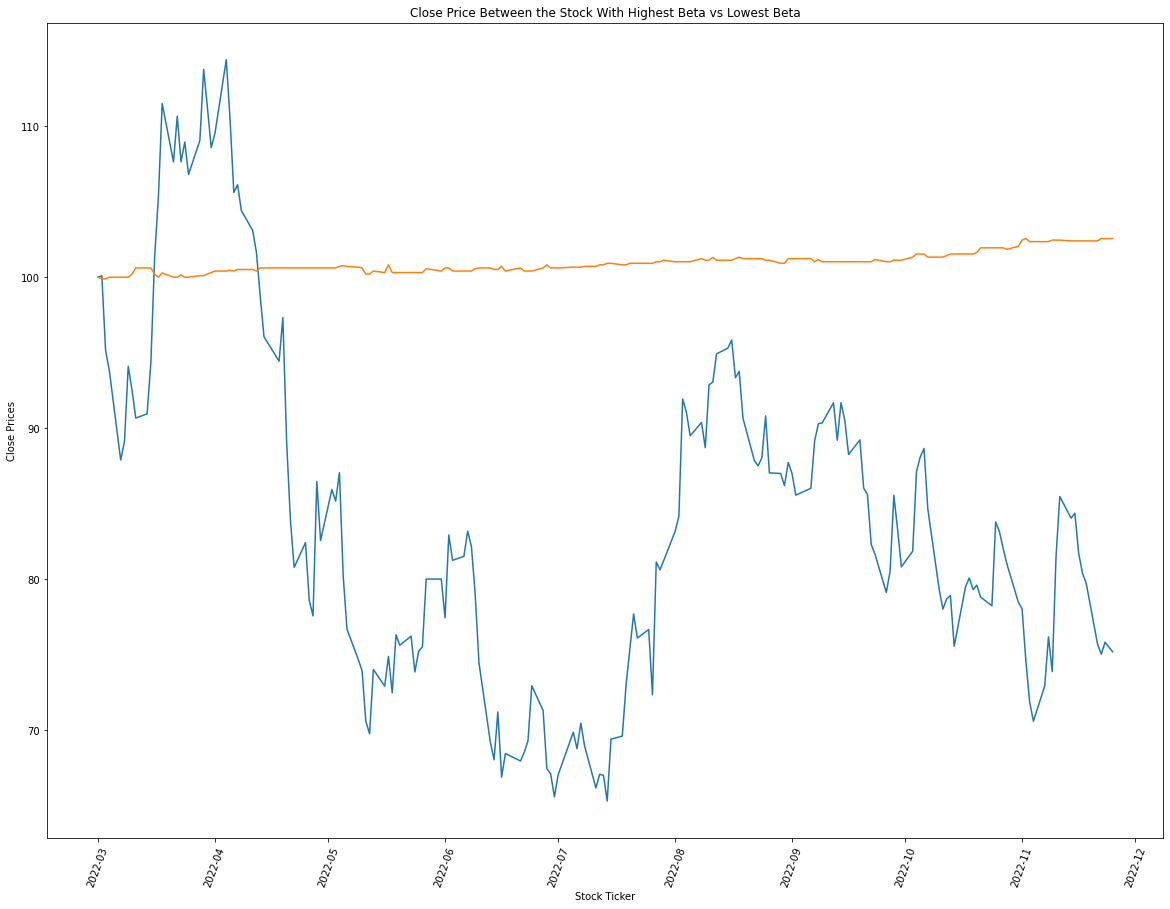

In [11]:
def graph_betas(max_beta, min_beta):
    max_beta_init_value = filtered_close_price_df[f'{max_beta_stock} Close'][0]
    min_beta_init_value = filtered_close_price_df[f'{min_beta_stock} Close'][0]
    plt.figure(figsize = (20,15))
    plt.plot(filtered_close_price_df[f'{max_beta_stock} Close'] * 100 / max_beta_init_value)
    plt.plot(filtered_close_price_df[f'{min_beta_stock} Close'] * 100 / min_beta_init_value)
    plt.title('Close Price Between the Stock With Highest Beta vs Lowest Beta') 
    plt.xlabel('Stock Ticker') 
    plt.ylabel('Close Prices')
    plt.xticks(rotation=70)
    
    #Displaying the plot
    plt.show()
graph_betas(max_beta_stock, min_beta_stock)

### Correlation
Since we are looking at a risky portfolio, we want positively correlated stocks to make sure we obtain stocks that move in the same direction relative to the market. As mentioned before, correlation would help us find tickers that move in the same direction as our "hero" ticker, thus creating a portfolio that is more risky. The formula for correlation is:

\begin{align*}
COR(X,Y)=\frac{COV(X,Y)}{\sigma_X \times \sigma_Y}
\end{align*}

To calculate for correlation, we created a function that takes in the hero stock and the dataframe of rate of returns. Since we want stocks that are very correlated with one another, the function returns 11 other stocks that have a correlation closest to 1 when compared with the "hero" stock. We then plotted a scatterplot of the correlation between the daily rate of returns of the "hero" stock and the returns of the stock that is the most correlated to that stock. The addition of a linear line of best fit shows the linear correlation between the two stocks. 

This is also known as Pearson's Correlation Coefficient.

In [12]:
def correlation(stock_ror, fin_ror_df):
    corr_list = []
    stock_list = []
    for tick in fin_ror_df:
        corr = fin_ror_df[tick].corr(stock_ror, method = 'pearson')
        corr_list.append(corr)
        tick_abrv = tick[0 : -len(' Daily Rate of Return')]
        stock_list.append(tick_abrv)
    corr_df = pd.DataFrame({'ticker' : stock_list, 'corr. with stock' : corr_list})
    corr_df = corr_df.set_index('ticker')
    return corr_df

In [13]:
def find_corr_stocks(hero_stock, stocks_ror_df):
    corr_df = correlation(stocks_ror_df[f'{hero_stock} Daily Rate of Return'], stocks_ror_df)
    corr_df = corr_df.sort_values(['corr. with stock'])
    return corr_df.index[-12:-1]
max_gain_portfolio = find_corr_stocks(max_beta_stock, filtered_ror_df)
max_loss_portfolio = find_corr_stocks(min_beta_stock, filtered_ror_df)
max_deviation_portfolio = find_corr_stocks(max_deviation_stock, filtered_ror_df)

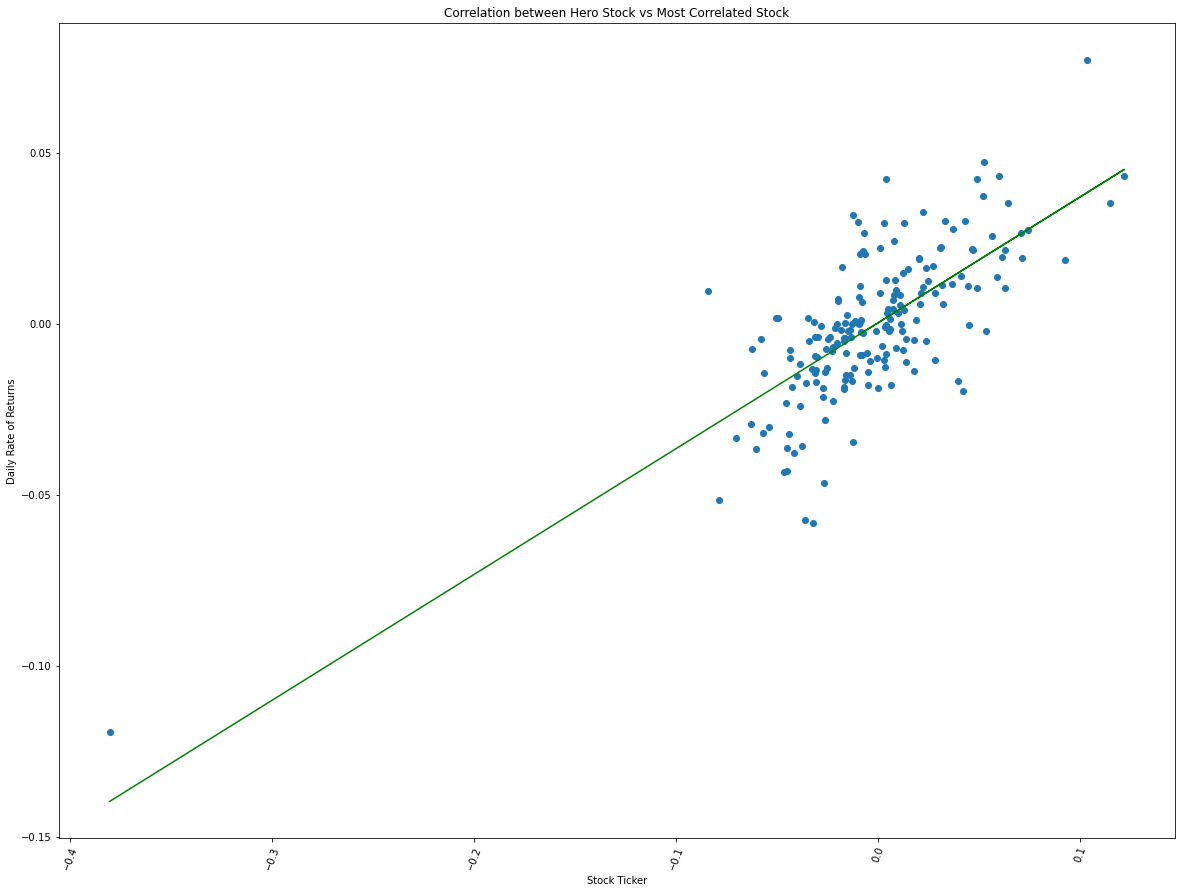

In [14]:
def graph_corr(hero_stock, most_correlated_stock):
    hero = filtered_ror_df[f'{max_beta_stock} Daily Rate of Return']
    most_correlated = filtered_ror_df[f'{max_deviation_portfolio[-1]} Daily Rate of Return']    
    plt.figure(figsize = (20,15))
    plt.scatter(hero, most_correlated)
    a, b = np.polyfit(hero, most_correlated, 1)
    plt.plot(hero, a*(hero)+b, color='green', linestyle='-')
    plt.title('Correlation between Hero Stock vs Most Correlated Stock') 
    plt.xlabel('Stock Ticker') 
    plt.ylabel('Daily Rate of Returns')
    plt.xticks(rotation=70)
    
    #Displaying the plot
    plt.show()
graph_corr(filtered_tickers_list, max_deviation_portfolio)

## Simulations

Using data from the past 8-9 months, we test the three min-max portfolios to see which one performs the best most frequently. For the date range our close-price data covers, we take every stretch of 5 consecutive trading days (roughly a week's performance), and for each determine the hero stock that performs the best.

The function simulate_mm_pf simulates the performance of putting the appropriate amount of money into each stock. Given a start date and an end date, the function simulates the historical performance of the portfolio over the given time period. The function then returns the fraction of the portfolio assigned to each stock in a dictionary, along with the performance of the simulation.

The function sim_winner takes in a list of hero stocks, a start date, an end date, a close price DataFrame and a Rate of Return Data Frame and produces the stock that performs the best when put into simulate_mm_pf.

The function sim_win_over_data counts the amount of times a list of hero stocks wins over the course of all the data in a DataFrame of close prices and rate of return and returns the hero stock that won the most.

In [15]:
pf_init_value = 500000
def simulate_mm_pf(hero_stock, corr_stocks, start_date, end_date, close_price_df):
    '''
        start_date and end_date must be trading days
    '''
    # Compiling the weights of the stocks
    weight = {}
    stock_count = 12
    min_weight = 1 / (2 * stock_count)
    max_weight = 0.25
    sidekick_weight = 1 - 2 * max_weight - 9 * min_weight
    
    # Isolating the data from the df we need
    pf_stock_info = pd.DataFrame()
    pf_stock_info[hero_stock] = close_price_df[f'{hero_stock} Close']
    for t in corr_stocks:
        pf_stock_info[t] = close_price_df[f'{t} Close']
    pf_stock_info = pf_stock_info[pf_stock_info.index >= start_date]
    pf_stock_info = pf_stock_info[pf_stock_info.index <= end_date]
    
    # Making a dictionary of weights for each individual stock
    weight[hero_stock] = max_weight
    for stock in corr_stocks:
        weight[stock] = min_weight
    weight[corr_stocks[-2]] = sidekick_weight
    weight[corr_stocks[-1]] = max_weight
    
    # Adjusting the values of the stock price to match initial investment amount
    pf_stock_info['total'] = pf_stock_info[hero_stock] * pf_init_value * max_weight / pf_stock_info[hero_stock].iloc[0]
    for stock in corr_stocks:
        pf_stock_info['total'] = pf_stock_info['total'] + (pf_stock_info[stock] * pf_init_value * 
                                                           weight[stock] / pf_stock_info[stock].iloc[0])
    
    # Returns the amount the stock deviated from its initial value
    performance = abs(pf_stock_info['total'].iloc[-1] - pf_init_value)
    return (weight, performance)

In [16]:
def sim_winner(hero_stocks, start_date, end_date, close_price_df, ror_df):
    performance = {}

    # Runs the simulation for each hero stock
    for hero in hero_stocks:
        corr_stocks = find_corr_stocks(hero, ror_df)
        performance[hero] = simulate_mm_pf(hero, corr_stocks, start_date, end_date, close_price_df)[1]
    
    # Returns the one that performed the best
    winner = max(performance, key = performance.get)
    return winner

In [24]:
def sim_win_over_data(hero_stocks, close_price_df, ror_df):
    '''
        Returns the hero stock with the highest success rate after running simulations on all data.
    '''
    trade_days = 5
    close_df = close_price_df.reset_index()
    win_dic = {}

    # Initializing the dictionary for each hero stock
    for hero in hero_stocks:
        win_dic[hero] = 0

    # Counting the number of times each hero stock wins
    for x in range(len(close_df.index) - trade_days + 1):
        temp_win = sim_winner(hero_stocks, 
                              close_df.loc[x, 'Date'], 
                              close_df.loc[x + trade_days - 1, 'Date'], 
                              close_price_df, ror_df)
        win_dic[temp_win] += 1
    
    return max(win_dic, key = win_dic.get)

ult_winner = sim_win_over_data([min_beta_stock, max_beta_stock, max_deviation_stock], 
                               filtered_close_price_df, 
                               filtered_ror_df)

In [25]:
def determine_winning_portfolio(most_volatile_stock):
    if ult_winner == max_beta_stock:
        print('max_beta')
    elif ult_winner == min_beta_stock:
        print('min_beta')
    else: 
        print('stdev')
    final_info_dict = simulate_mm_pf(most_volatile_stock, find_corr_stocks(ult_winner, filtered_ror_df), filtered_close_price_df.index[0], 
                              filtered_close_price_df.index[-1], filtered_close_price_df)
    return final_info_dict
winning_info_dict = determine_winning_portfolio(ult_winner)[0]

max_beta


# Creating Final Portfolio
In this final section we use the data structures created throughout our analysis to extract and derive important figures about each of the stocks in our investment. We will create a final portfolio dataframe which holds this necessary information. We end this project by outputting a condensed version of this dataframe as a csv file, holding the key details of The6ixRoboAdvisor's investment recommendation.

In [26]:
def create_final_portfolio(portfolio_info, initial_investment):
    
    #Create final dataframe with initial ticker and weight data which is easily accessed
    data = {'Ticker':winning_info_dict.keys(), 'Weight':winning_info_dict.values()}
    Portfolio_Final = pd.DataFrame(data)
    
    #Append the prices of each stock into a list
    prices = []
    for tick in Portfolio_Final.Ticker:
        prices.append(filtered_close_price_df.loc['11-25-2022', f'{tick} Close'])
        
    #Insert the remaining required columns into the right position in the final dataframe
    Portfolio_Final.insert(1, 'Price', prices)
    Portfolio_Final.insert(2, 'Shares', (initial_investment * Portfolio_Final['Weight']) / Portfolio_Final['Price'])
    Portfolio_Final.insert(3, 'Value', Portfolio_Final['Shares'] * Portfolio_Final['Price'])
    
    #Ensure weights are expressed as percentages and indexes start from 1 to the number of stocks invested in
    Portfolio_Final.Weight *= 100
    Portfolio_Final.index += 1 
    return Portfolio_Final
Portfolio_Final = create_final_portfolio(winning_info_dict, 500000)
Portfolio_Final

,Ticker,Price,Shares,Value,Weight
1,PYPL,80.080002,1560.939025,125000.000000,25.000000
2,QCOM,123.449997,168.759286,20833.333333,4.166667
3,AAPL,148.110001,140.661220,20833.333333,4.166667
4,MSFT,247.490005,84.178483,20833.333333,4.166667
5,SBUX,99.559998,209.254056,20833.333333,4.166667
6,TXN,177.070007,117.655913,20833.333333,4.166667
7,NKE,105.959999,196.615077,20833.333333,4.166667
8,BLK,737.780029,28.237866,20833.333333,4.166667
9,BK,45.669998,456.171101,20833.333333,4.166667
10,GM,40.459999,514.911859,20833.333333,4.166667


In [27]:
#Here we simply create a csv file corresponding to the final dataframe's index, ticker and shares column
def build_investment_csv(final_portfolio):
    Stocks_Final = Portfolio_Final[['Ticker','Shares']]
    Stocks_Final.to_csv('Stocks_Group_6.csv')
Stocks_Group_6_CSV = build_investment_csv(Portfolio_Final)

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Haaris, Andrew and Alan